In [1]:
import pathlib
import json
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import load_npz
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# --- 1. Load Data and Artifacts ---

# Paths
PROC = pathlib.Path("data_proc")

# Load TF-IDF matrices
X_train = load_npz(PROC / "X_train.npz")
X_val = load_npz(PROC / "X_val.npz")
X_test = load_npz(PROC / "X_test.npz")

# Load labels
y_train = pd.read_csv(PROC / "y_train.csv").values.ravel()
y_val = pd.read_csv(PROC / "y_val.csv").values.ravel()
y_test = pd.read_csv(PROC / "y_test.csv").values.ravel()

# Load emotion mapping
with open(PROC / "emotion_label_map.json", "r") as f:
    emo_id2name = json.load(f)
    # Convert keys to int since JSON loads them as strings
    emo_id2name = {int(k): v for k, v in emo_id2name.items()}

emotion_labels = [emo_id2name[i] for i in sorted(emo_id2name.keys())]

print("Data loading complete.")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print("Emotion labels:", emotion_labels)

Data loading complete.
X_train shape: (87957, 5000)
y_train shape: (87957,)
Emotion labels: ['anger', 'disgust', 'fear', 'happiness', 'no_emotion', 'sadness', 'surprise']


In [2]:
# --- 2. Train Baseline Model ---

SEED = 17

# Initialize and train the Logistic Regression model
print("Training Logistic Regression baseline model...")

baseline_model = LogisticRegression(
    random_state=SEED,
    max_iter=1000  # Ensure convergence
)

baseline_model.fit(X_train, y_train)

print("Model training complete.")

Training Logistic Regression baseline model...


Model training complete.


Evaluating model on the validation set...

Classification Report (Validation Set):
              precision    recall  f1-score   support

       anger       0.56      0.30      0.39       758
     disgust       0.68      0.21      0.32       239
        fear       0.66      0.33      0.44       793
   happiness       0.58      0.65      0.61      3313
  no_emotion       0.59      0.76      0.66      3312
     sadness       0.54      0.55      0.55      1866
    surprise       0.48      0.18      0.26       714

    accuracy                           0.58     10995
   macro avg       0.59      0.43      0.46     10995
weighted avg       0.58      0.58      0.56     10995

Overall Accuracy: 0.5788

Confusion Matrix (Validation Set):


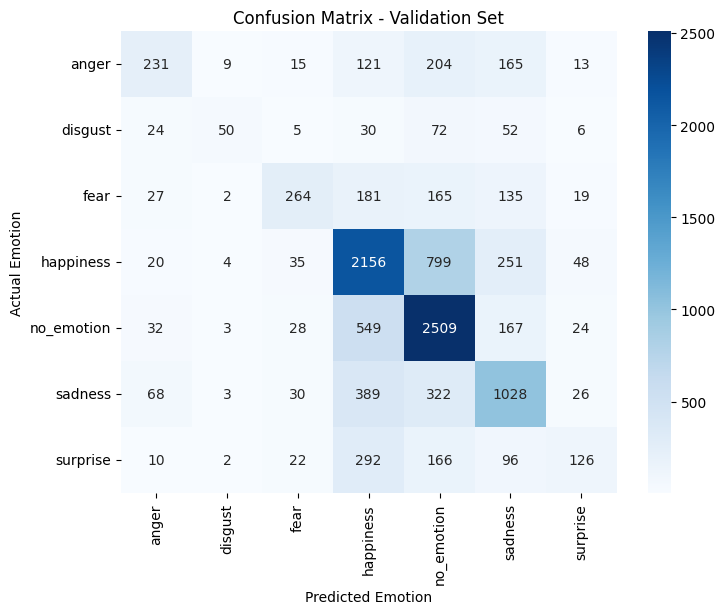

In [3]:
# --- 3. Evaluate Model Performance on Validation Set ---

# Make predictions on the validation data
print("Evaluating model on the validation set...")
y_pred_val = baseline_model.predict(X_val)

# Generate and print the classification report
print("\nClassification Report (Validation Set):")
report = classification_report(y_val, y_pred_val, target_names=emotion_labels)
print(report)

# Calculate and print overall accuracy
accuracy = accuracy_score(y_val, y_pred_val)
print(f"Overall Accuracy: {accuracy:.4f}")

# Generate and plot the confusion matrix
print("\nConfusion Matrix (Validation Set):")
cm = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title('Confusion Matrix - Validation Set')
plt.ylabel('Actual Emotion')
plt.xlabel('Predicted Emotion')
plt.show()

In [4]:
# --- 4. Save Model and Evaluation Report ---

# Define paths for artifacts
MODELS = pathlib.Path("models")
MODELS.mkdir(exist_ok=True)

model_path = MODELS / "logistic_regression_baseline.joblib"
report_path = MODELS / "baseline_evaluation_report.txt"

# Save the trained model
joblib.dump(baseline_model, model_path)
print(f"Model saved to: {model_path}")

# Save the classification report to a file
with open(report_path, "w") as f:
    f.write("Baseline Model: Logistic Regression with TF-IDF\n")
    f.write("==================================================\n\n")
    f.write("Classification Report (Validation Set):\n")
    f.write(report)
    f.write("\n")
    f.write(f"Overall Accuracy: {accuracy:.4f}\n")

print(f"Evaluation report saved to: {report_path}")

Model saved to: models/logistic_regression_baseline.joblib
Evaluation report saved to: models/baseline_evaluation_report.txt


In [5]:
# --- 5. Final Evaluation on Test Set ---

print("Evaluating final model on the test set...")

# Load the saved model
final_model = joblib.load(model_path)

# Make predictions on the test data
y_pred_test = final_model.predict(X_test)

# Generate and print the classification report for the test set
print("\nClassification Report (Test Set):\n")
final_report = classification_report(y_test, y_pred_test, target_names=emotion_labels)
print(final_report)

# Save the final report
final_report_path = MODELS / "logistic_regression_final_report.txt"
with open(final_report_path, "w") as f:
    f.write("Final Model: Logistic Regression with TF-IDF (Augmented & Balanced Data)\n")
    f.write("=======================================================================\n\n")
    f.write(final_report)

print(f"\nFinal evaluation report saved to: {final_report_path}")

Evaluating final model on the test set...

Classification Report (Test Set):

              precision    recall  f1-score   support

       anger       0.53      0.30      0.38       757
     disgust       0.79      0.23      0.35       240
        fear       0.61      0.33      0.43       793
   happiness       0.56      0.65      0.60      3312
  no_emotion       0.59      0.74      0.66      3313
     sadness       0.53      0.51      0.52      1865
    surprise       0.44      0.14      0.22       715

    accuracy                           0.57     10995
   macro avg       0.58      0.41      0.45     10995
weighted avg       0.56      0.57      0.55     10995


Final evaluation report saved to: models/logistic_regression_final_report.txt
